In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import yfinance as yf

from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed


from binance.client import Client
import time
warnings.filterwarnings("ignore", category=FutureWarning)


from utilities.Data_Ordering import (
    load_and_process_price_data,
    trim_and_split_price_table,
    remove_outliers,
    load_and_process_crypto_data,
    split_price_table_by_months,
    
)

from utilities.Statistical_Bootstrap import (
    ou_bootstrap,
    print_ou_estimates,
    plot_bootstrap_distributions,
    plot_optimal_trading_bands,
    plot_CI_mu,
)

from utilities.Optimal_Bands import (
    optimal_trading_bands,
)

### Data download (Already done in the crypto dataset folder)

# **New Dataset Analysis: BTC-XRP, BTC-ADA**

In this section, we analyze a new trading pair: **Bitcoin (BTC)** and **Ripple (XRP)**. The spread between these two assets is modeled as a mean-reverting process, and we aim to evaluate whether statistical arbitrage opportunities exist in this pair.

We follow the same methodology as in the previous analysis, applying the Ornstein-Uhlenbeck (OU) framework:

$$
dX_t = \lambda (\theta - X_t) dt + \sigma dW_t
$$

This allows us to:

- Estimate the OU parameters using historical BTC-XRP/BTC-ADA data  
- Construct optimal trading bands based on model calibration  
- Simulate strategy performance under realistic trading assumptions

We also compare the results with previous asset pairs to assess robustness and profitability under different market conditions.

> ⚠️ **Note:**  
> The section below has been commented out because it performs dataset loading and preprocessing, which can be very time-consuming.  
> The resulting datasets have already been saved in the `crypto_dataset` folder, so this section can be skipped to save time.

In [ ]:

# # List of crypto pairs
# symbols = ['BTCUSDT', 'XRPUSDT', 'ADAUSDT']

# def get_1min_data(symbol, interval='1m', lookback_days=180):
#     end_time = int(time.time() * 1000)
#     start_time = end_time - lookback_days * 24 * 60 * 60 * 1000
#     df_list = []
    
#     while start_time < end_time:
#         klines = client.get_klines(symbol=symbol, interval=interval,
#                                    startTime=start_time, limit=1000)
#         if not klines:
#             break
#         df = pd.DataFrame(klines, columns=[
#             'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
#             'Close time', 'Quote asset volume', 'Number of trades',
#             'Taker buy base volume', 'Taker buy quote volume', 'Ignore'
#         ])
#         df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
#         df_list.append(df)
#         start_time = klines[-1][0] + 60_000  # move 1 min forward
#         time.sleep(0.5)  # respect rate limits
    
#     return pd.concat(df_list, ignore_index=True)

# # Download data for all 10 cryptos
# crypto_data = {}
# for symbol in symbols:
#     print(f"Downloading: {symbol}")
#     df = get_1min_data(symbol)
#     crypto_data[symbol] = df
#     df.to_csv(f'{symbol}_1min_6months.csv', index=False)
#     print(f"Saved {symbol} ({len(df)} rows)")

### **Testing for Ornstein-Uhlenbeck** 

> 📌 **Dataset Selection Rationale**  
> Although we initially downloaded data for 10 cryptocurrency pairs, we ended up using only 2 of them for our final experiments.  
> All 10 pairs were tested during the development phase in order to identify the most promising ones.  
> However, since testing all of them was very time-consuming and the performance of the remaining pairs was significantly lower,  
> we decided to retain and present results only for the top 2 pairs.  
> This approach allowed us to reduce computation time while focusing the analysis on the most relevant assets.

It may take some time (40 sec per pair with Mac M3)

In [3]:
from statsmodels.tsa.stattools import adfuller

symbols = ['BTCUSDT', 'XRPUSDT','ADAUSDT']

def process_pair(pair, max_points=259000):
    sym1, sym2 = pair
    file1 = f"./crypto_dataset/{sym1}_1min_6months.csv"
    file2 = f"./crypto_dataset/{sym2}_1min_6months.csv"
    
    try:
        df = load_and_process_crypto_data(file1, file2,
                                          start_date="2024-12-01", end_date="2025-05-31")
        
        # Use only the last `max_points` of Rt
        Rt = df['Rt'].dropna()
        Rt_subset = Rt[-max_points:]  # last 1000 points
        
        adf_result = adfuller(Rt_subset)
        adf_stat = adf_result[0]
        p_value = adf_result[1]
        
        result = {
            'Pair': f'{sym1}/{sym2}',
            'ADF Statistic': adf_stat,
            'p-value': p_value
        }
        print(f"Checked {sym1}/{sym2}: ADF={adf_stat:.4f}, p={p_value:.4f}")
        return result

    except Exception as e:
        print(f"Error with pair {sym1}/{sym2}: {e}")
        return None

if __name__ == "__main__":
    pairs = [('BTCUSDT', symbol) for symbol in symbols if symbol != 'BTCUSDT']
    results = []

    for pair in pairs:
        result = process_pair(pair)
        if result is not None:
            results.append(result)

    print("\nAll pairs checked.")



<class 'pandas.core.series.Series'>
Checked BTCUSDT/XRPUSDT: ADF=-3.3054, p=0.0146
<class 'pandas.core.series.Series'>
Checked BTCUSDT/ADAUSDT: ADF=-3.8052, p=0.0029

All pairs checked.


In [4]:
# Load and preprocess futures data from Excel

file1 = f"./crypto_dataset/BTCUSDT_1min_6months.csv"
file2 = f"./crypto_dataset/XRPUSDT_1min_6months.csv"
file3 = f"./crypto_dataset/ADAUSDT_1min_6months.csv"

df_output = load_and_process_crypto_data(file1, file2, time_col='Open time', ticks=None, convs=None,
                                 start_date=None, end_date=None, add_spread_col=True)

# Split data into In-Sample (IS) and Out-of-Sample (OS) sets based on time of day and first 9 months
data_IS, data_OS = split_price_table_by_months(
    df_output,
    split_months=4
)


<class 'pandas.core.series.Series'>


### **Parameter Estimation**

Using the historical BTC-XRP spread data, we estimate the key parameters of the underlying stochastic process. The focus is on capturing the dynamics of mean reversion and volatility without overfitting.

Estimation is carried out via Maximum Likelihood, providing the following outputs:

- Speed of reversion (**λ**)  
- Long-run equilibrium level (**θ**)  
- Volatility (**σ**)

Where relevant, confidence intervals are computed via bootstrapping to assess robustness.

This may take a while (30 sec with Mac M3)


Estimates for IS dataset :
Ornstein-Uhlenbeck Parameter Estimates
---------------------------------------------
k     : Estimate = 78.612326, 95% CI = [54.107484, 133.570633]
eta   : Estimate = 10.539042, 95% CI = [10.492762, 10.588477]
sigma : Estimate = 1.054204, 95% CI = [1.050618, 1.057721]


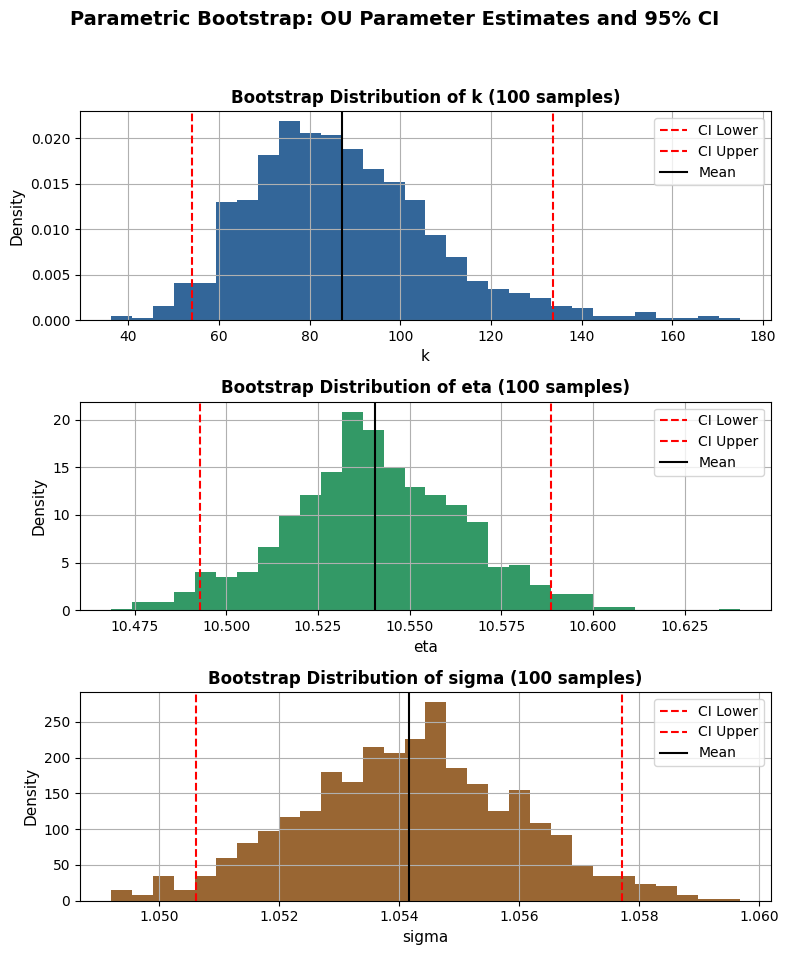

In [5]:

parameters = ou_bootstrap(data_IS)
print("\nEstimates for IS dataset :")
print_ou_estimates(parameters)
plot_bootstrap_distributions(parameters, M=100)


### **Optimal Bands & Leverage**

Based on the estimated parameters, we compute the optimal trading thresholds that define entry and exit points. These bands are derived to maximize the expected return while controlling for transaction costs and risk.

The leverage level is also calibrated to enhance profitability under the constraint of a fixed stop-loss, ensuring the strategy remains within acceptable risk limits.

This section includes:

- Calculation of upper and lower trading bands  
- Determination of optimal leverage ratio  
- Visual inspection of trading regions over historical price paths

 Stop-loss Leverage       d*  d_CI_low  d_CI_high        u*  u_CI_low  u_CI_high         μ  mu_CI_low  mu_CI_high        f*  f_CI_low f_CI_high
    -1.282        1 0.980147  0.964866   0.990554  0.514387  0.508061   0.519153  1.818805   1.517879    2.351467                              
    -1.282        2 0.962297  0.947255   0.974844  0.398784  0.385921   0.415027  3.065374   2.475595    4.114457                              
    -1.282        5 1.039084  0.985428   1.081118  0.176856  0.143858   0.218962  4.477070   3.228699    6.805462                              
    -1.282      opt 1.044494  1.023818   1.058123  0.167787  0.150846   0.183955  4.479810   3.265260    7.062833   5.15516  4.406939  6.424924
    -1.645        1 0.828467  0.826733   0.832363  0.433929  0.431764   0.438548  2.500389   2.079713    3.251382                              
    -1.645        2 0.781715  0.779744   0.790491  0.301304  0.278212   0.332488  4.391122   3.557818    5.880043                       

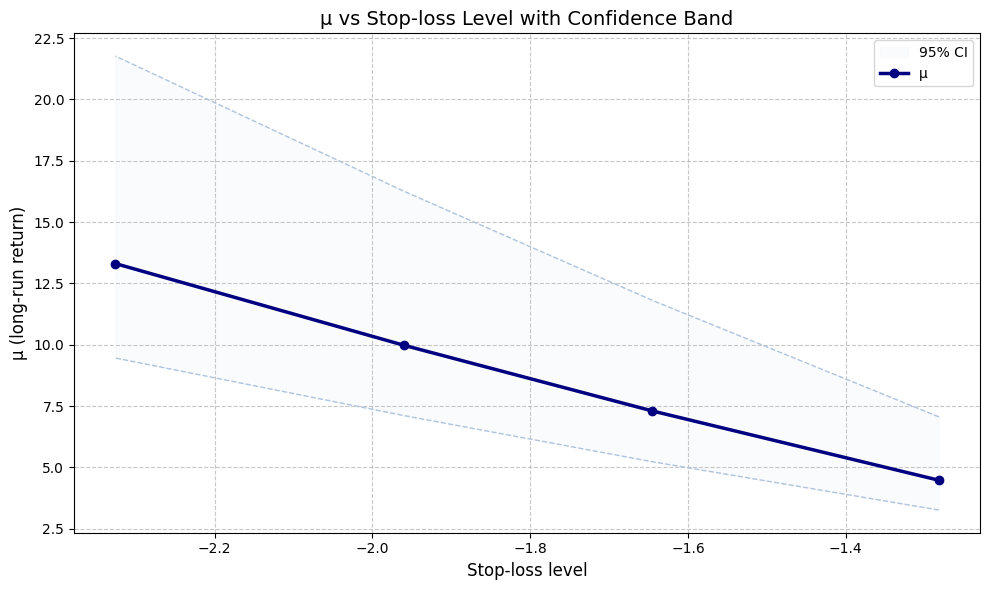

In [6]:
# Compute transaction costs (log-bid/ask spreads)
C_t = np.log(data_IS['Ask1'] / data_IS['Bid1']) + \
      np.log(data_IS['Ask2'] / data_IS['Bid2'])

C = np.mean(C_t)  # average log transaction cost

l_list = [-1.282, -1.645, -1.96, -2.326]        # stop-loss levels in σ-units
f_list = [1, 2, 5, 'opt']                       # leverage to test
M      = 100000                                   
alpha  = 0.05                                   # confidence level
grid   = 100                                    # grid size for optimization


results = []

for l in l_list:
    for f in f_list:
        R = optimal_trading_bands(M=M, l=l, f=f, P=parameters, C=C, alpha=alpha,grid=grid)
        row = {
            "Stop-loss": l,
            "Leverage": f,
            "d*": R['d_estimated'],
            "d_CI_low": R['d_CI'][0],
            "d_CI_high": R['d_CI'][1],
            "u*": R['u_estimated'],
            "u_CI_low": R['u_CI'][0],
            "u_CI_high": R['u_CI'][1],
            "μ": R['mu_estimated'],
            "mu_CI_low": R['mu_CI'][0],
            "mu_CI_high": R['mu_CI'][1],
            "f*": R['f_estimated'] if f == 'opt' else '',
            "f_CI_low": R['f_opt_CI'][0] if f == 'opt' else '',
            "f_CI_high": R['f_opt_CI'][1] if f == 'opt' else '',
        }
        results.append(row)

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

plot_CI_mu(df_results[df_results['Leverage'] == 'opt'], alpha)

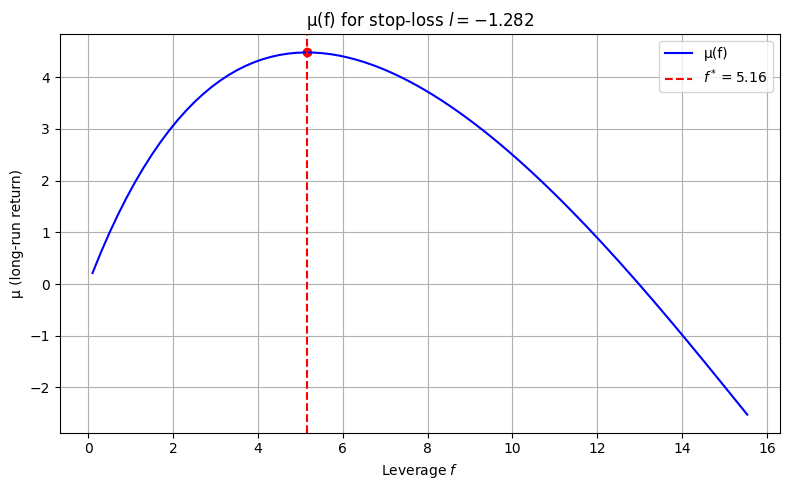

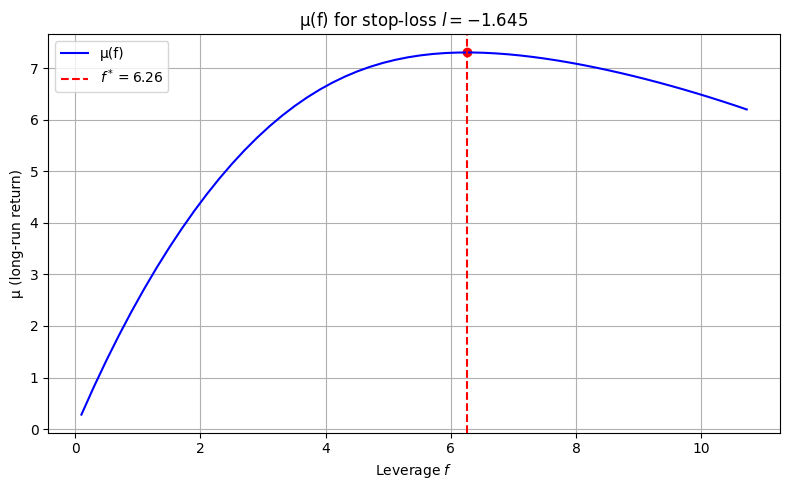

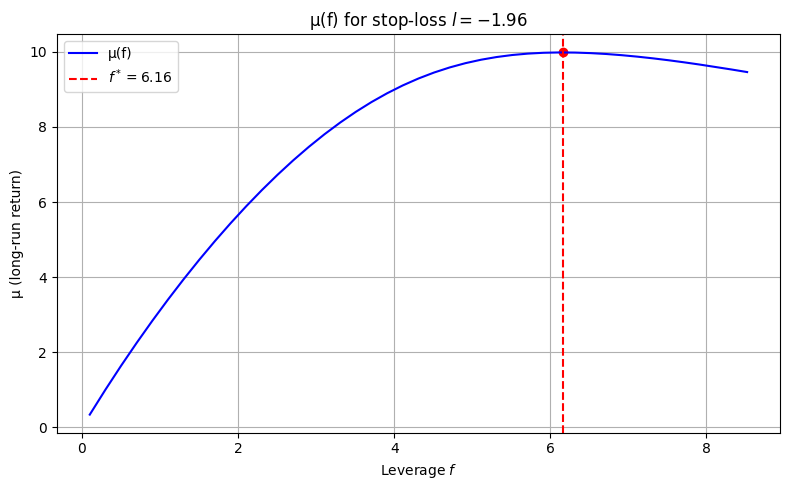

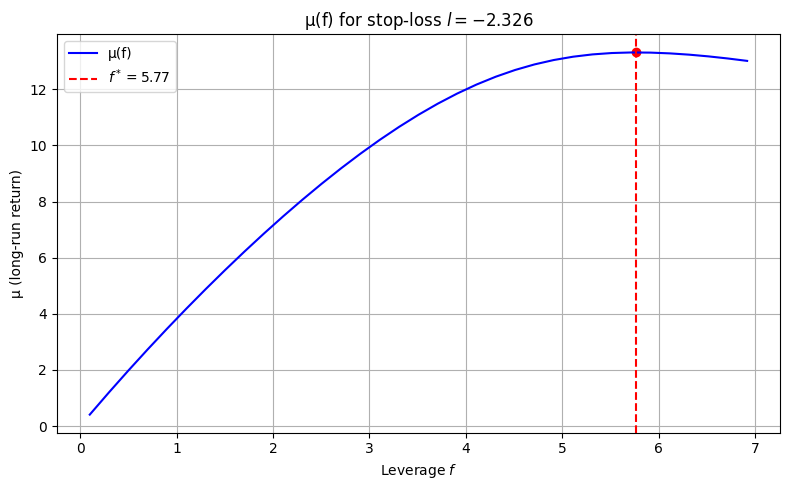

In [7]:
f_grid = np.linspace(0.1, 40, 200)

for l in l_list:
    mu_values = []

    # OU parameters from the 8-16 IS dataset
    k_hat = parameters['parameters']['k'].values[0]
    sigma_hat = parameters['parameters']['sigma'].values[0]
    theta = 1 / k_hat
    sigma_stat = sigma_hat / np.sqrt(2 * k_hat)
    c = C / sigma_stat

    # Compute mu(f) for each f
    for f in f_grid:
        R = optimal_trading_bands(M=1, l=l, f=f, P=parameters, C=C, alpha=alpha,grid=grid)
        mu_values.append(R['mu_estimated'])

    R_opt = optimal_trading_bands(M=1, l=l, f='opt', P=parameters, C=C, alpha=alpha,grid=grid)
    f_star = R_opt['f_estimated']
    mu_star = R_opt['mu_estimated']

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(f_grid, mu_values, label='μ(f)', color='blue')
    plt.axvline(f_star, color='red', linestyle='--', label=f'$f^* = {f_star:.2f}$')
    plt.scatter([f_star], [mu_star], color='red')
    plt.xlabel("Leverage $f$")
    plt.ylabel("μ (long-run return)")
    plt.title(f"μ(f) for stop-loss $l = {l}$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()